In [1]:
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import itertools

from scipy.sparse import coo_matrix
from scipy.sparse.linalg import spsolve
from jax import random, vmap, jit
from jax.lax import scan

%config InlineBackend.figure_format='retina'

# Elliptic D=1

BVP

\begin{equation}
  \begin{split}
  -&\frac{d}{dx}\left(\sigma(x) \frac{d u(x)}{dx}\right) = f(x),\\
  &u(0) = u(1) = 0,
  \end{split}
\end{equation}

where

\begin{equation}
  \begin{split}
      &\sigma = az + b, z\sim \mathcal{N}\left(0, \left(I - c\Delta\right)^{-k}\right);\\
      &f \sim \mathcal{N}\left(0, \left(I - c\Delta\right)^{-k}\right).
  \end{split}
\end{equation}

In [2]:
def get_coordinates(N):
    x = jnp.linspace(0, 1, N+2)[1:]
    h = x[1] - x[0]
    x_half = x - h/2
    return x_half, x[:-1]

def get_matrix(sigma_half):
    A = jnp.diag(sigma_half[:-1] + sigma_half[1:]) - jnp.diag(sigma_half[1:-1], k=-1) - jnp.diag(sigma_half[1:-1], k=1)
    return A

def get_matrices(x, N, p, l):
    return jnp.stack([jnp.exp(1j*x*2*jnp.pi*k) / (1 + (2*jnp.pi*k / l)**2)**p for k in range(N)], 1)

def get_diffusion_coefficient(key, M, s):
    coeff = random.normal(key, (M.shape[1],), dtype=jnp.complex64)
    sigma = jnp.real(M @ coeff)
    sigma = s*(sigma - jnp.min(sigma)) / (jnp.max(sigma) - jnp.min(sigma)) + 1
    return sigma

def piecewise_linear_diffusion_coefficient(key, x, s, k):
    keys = random.split(key)
    vals = random.uniform(keys[0], (k,), minval=1, maxval=s)
    coords = random.uniform(keys[1], (k,))
    coords = coords.at[0].set(0)
    coords = coords.at[-1].set(1)
    return jnp.interp(x, coords, vals)

def get_data(key, N_samples, constant_rhs=False, laplace=False, N = 100, s=4):
    M = 150
    p = 2
    l = 10
    k = 5
    x_half, x = get_coordinates(N)
    h = x[1] - x[0]
    T = get_matrices(x_half, M, p, l)
    T_x = get_matrices(x, M, p, l)
    keys = random.split(key, N_samples)

    features = []
    targets = []
    Matrices = []
    for key in keys:
        key1, key2 = random.split(key)
        if laplace:
            sigma = jnp.ones_like(x_half)
        else:
            sigma = get_diffusion_coefficient(key1, T, s)
        A = get_matrix(sigma)

        if constant_rhs:
            b = jnp.ones((N,))
        else:
            coeff = random.normal(key2, (T_x.shape[1],), dtype=jnp.complex64)
            b = jnp.real(T_x @ coeff)
        b = h**2 * b
        sol = jnp.linalg.solve(A, b)
        sigma = get_diffusion_coefficient(key1, T_x, s)
        if laplace:
            sigma = jnp.ones_like(x)
        features.append(jnp.stack([sigma, b/h**2]))
        targets.append(sol)
    features = jnp.stack(features, 0)
    targets = jnp.expand_dims(jnp.stack(targets, 0), 1)
    return features, targets, jnp.expand_dims(x, 0)

def get_dataset_elliptic_1D(name, N_samples=1000, key=random.PRNGKey(33), N=100, s=4, normalize=False):
    if name == "Dataset 1":
        features, targets, coordinates = get_data(key, N_samples, constant_rhs=False, laplace=False, N=N, s=s)
    elif name == "Dataset 2":
        features, targets, coordinates = get_data(key, N_samples, constant_rhs=True, laplace=False, N=N, s=s)
    else:
        features, targets, coordinates = get_data(key, N_samples, constant_rhs=False, laplace=True, N=N, s=s)

    if normalize:
        features_scale = jnp.max(jnp.max(jnp.abs(features), axis=2, keepdims=True), axis=0, keepdims=True)
        targets_scale = jnp.max(jnp.max(jnp.abs(targets), axis=2, keepdims=True), axis=0, keepdims=True)
        features = features / features_scale
        targets = targets / targets_scale
    return features, targets, coordinates

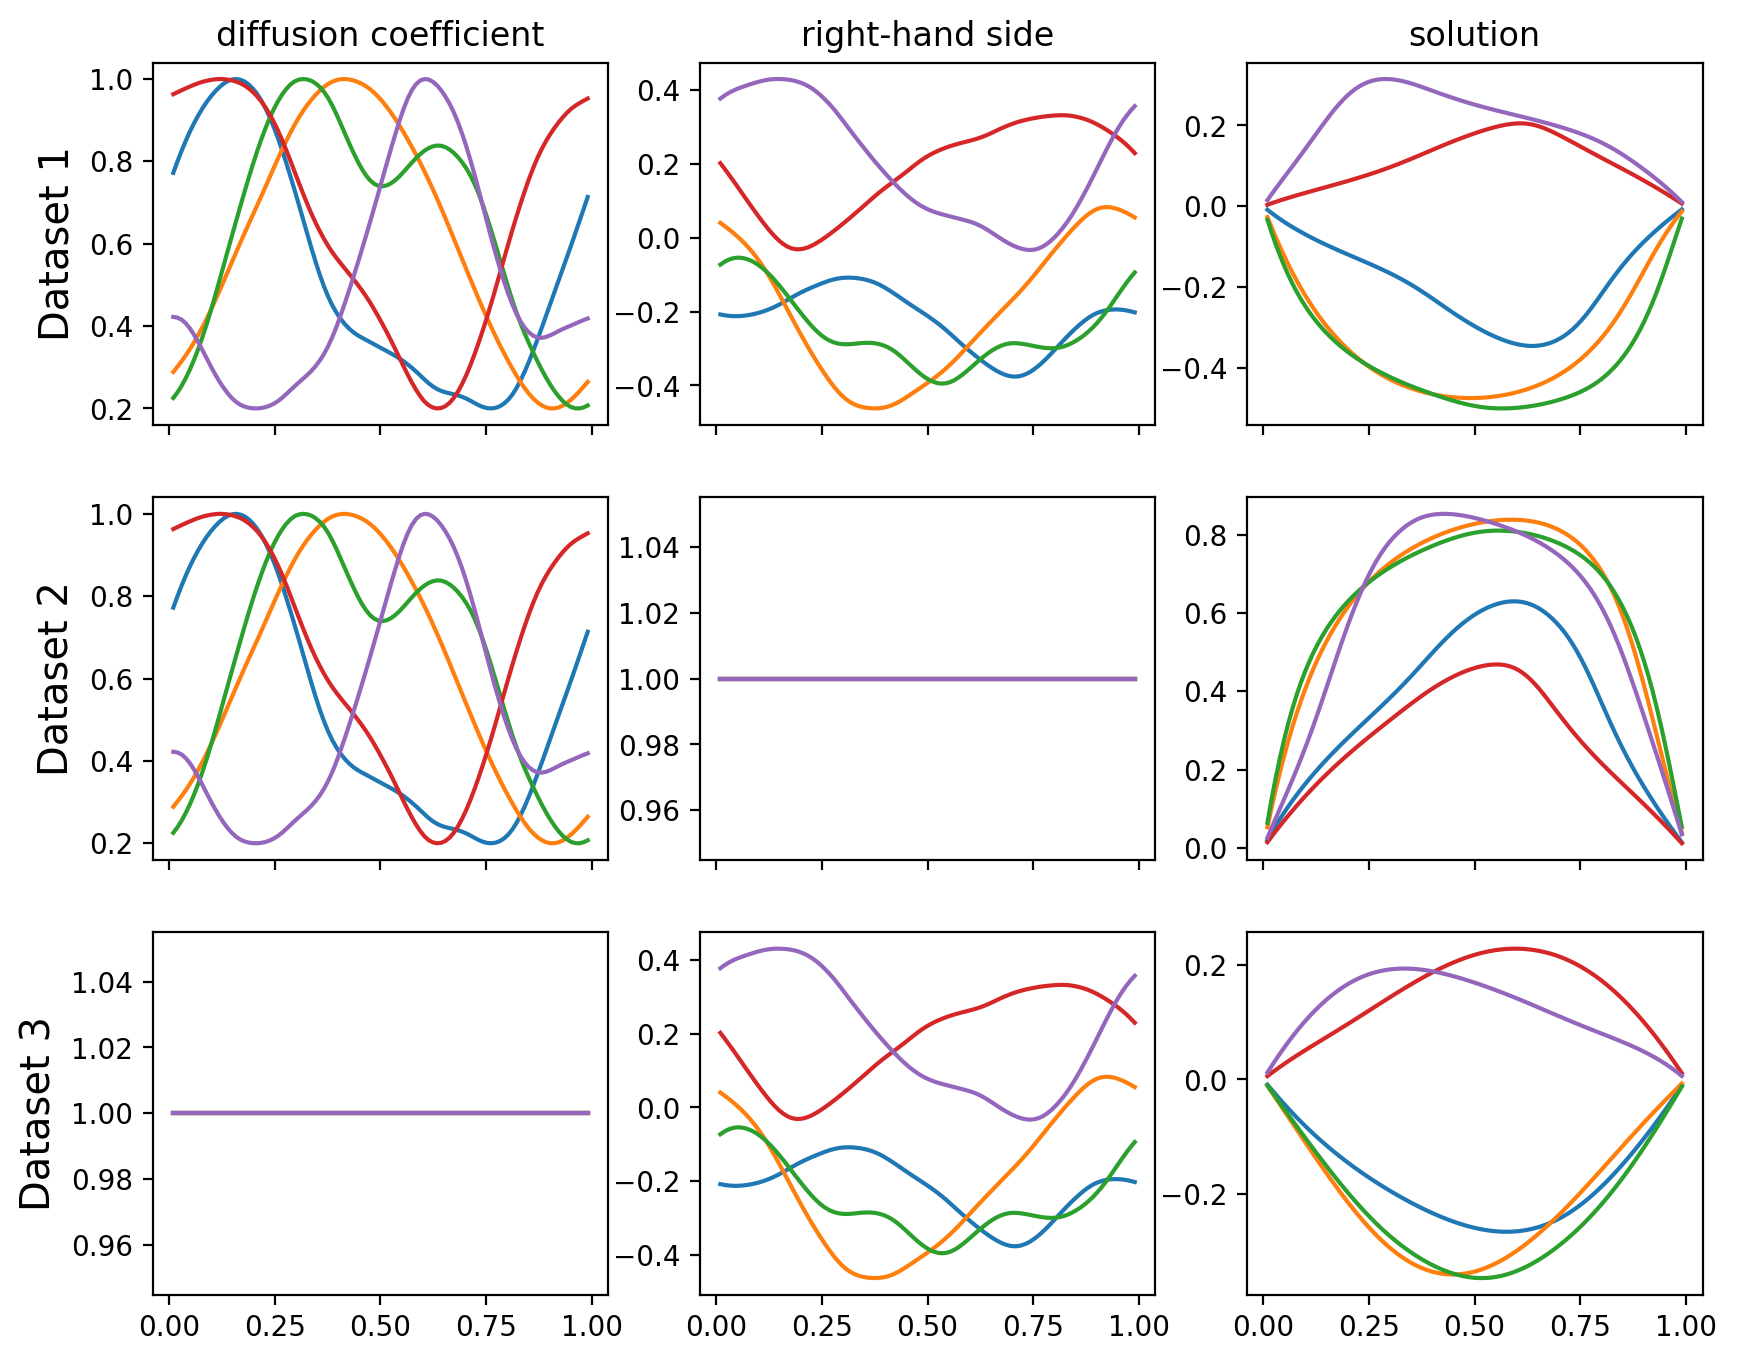

In [3]:
fig, ax = plt.subplots(3, 3, figsize=(10, 8), sharex=True)
N_samples = 20

for i in range(3):
    name = f"Dataset {i+1}"
    features, targets, coords = get_dataset_elliptic_1D(name, N_samples=N_samples, normalize=True)
    for s in [0, 5, 12, 15, 17]:
        ax[i, 0].plot(coords[0], features[s, 0])
        ax[i, 1].plot(coords[0], features[s, 1])
        ax[i, 2].plot(coords[0], targets[s, 0])
    ax[i, 0].set_ylabel(name, fontsize="x-large")

for i, n in enumerate(["diffusion coefficient", "right-hand side", "solution"]):
    ax[0, i].set_title(n)

# Elliptic D=2

BVP

\begin{equation}
  \begin{split}
    -&\frac{\partial}{\partial x}\left(\sigma(x, y) \frac{\partial u(x, y)}{\partial x}\right) -\frac{\partial}{\partial y}\left(\sigma(x, y) \frac{\partial u(x, y)}{\partial y}\right)  = f(x, y),\\
    &u(x, 0) = u(x, 1) = u(0, y) = u(1, y) = 0.
  \end{split}
\end{equation}

where

\begin{equation}
  \begin{split}
      &\sigma = \exp(z), z\sim \mathcal{N}\left(0, \left(I - c\Delta\right)^{-k}\right);\\
      &f \sim \mathcal{N}\left(0, \left(I - c\Delta\right)^{-k}\right).
  \end{split}
\end{equation}

In [4]:
def get_frequencies_and_weights(N, p, l):
    f = 2*jnp.pi*jnp.array([*itertools.product(range(N), repeat=2)])
    w = 1/(1 + (jnp.sum(f, 1)/l)**2)**p
    return f, w

def random_polynomial(x, y, freq, weight, coeff):
    return jnp.real(jnp.sum(jnp.exp(1j*freq[:, 0]*x + 1j*freq[:, 1]*y)*coeff*weight))

@jit
def diffusion_coefficient(x, y, freq, weight, coeff):
    return jnp.exp(random_polynomial(x, y, freq, weight, coeff))

def FD_2D(N_points, F):
    N = M = N_points
    sigma, f = F
    def get_indices_scan(carry, c):
        coords, h_x, h_y, N, M = carry
        row = [c,]*5
        col = []
        val = []
        for i in [+1, -1]:
            x, y = coords[c[0], c[1]]
            val.append(-sigma(x, y + h_y*i/2) / h_y**2)
            col.append(jnp.array([c[0], c[1] + i]))
            val.append(-sigma(x + h_x*i/2, y) / h_x**2)
            col.append(jnp.array([c[0] + i, c[1]]))
        val.append(-sum(val))
        col.append(c)
        return carry, [jnp.array(row), jnp.array(col), jnp.array(val)]

    x = jnp.linspace(0, 1, N+2)[1:-1]
    y = jnp.linspace(0, 1, M+2)[1:-1]
    h_x = x[1] - x[0]
    h_y = y[1] - y[0]
    coords = jnp.stack(jnp.meshgrid(x, y, indexing='ij'), 2)
    ind = jnp.stack(jnp.meshgrid(jnp.arange(N), jnp.arange(M), indexing='ij'), 2).reshape(-1, 2)

    carry = coords, h_x, h_y, N, M
    carry, [rows, cols, vals] = scan(get_indices_scan, carry, ind)

    good_indices = (cols[:, :, 0] != -1) * (cols[:, :, 0] != N) * (cols[:, :, 1] != -1) * (cols[:, :, 1] != M)
    good_indices = good_indices * (rows[:, :, 0] != -1) * (rows[:, :, 0] != N) * (rows[:, :, 1] != -1) * (rows[:, :, 1] != M)

    rows = rows[good_indices]
    cols = cols[good_indices]
    vals = vals[good_indices]

    rows = rows[:, 1] + rows[:, 0] * M
    cols = cols[:, 1] + cols[:, 0] * M
    lex_ind = ind[:, 1] + ind[:, 0] * M

    rows, cols, vals = np.array(rows), np.array(cols), np.array(vals)

    ind = np.stack([rows, cols], 1)
    A = coo_matrix((vals, (rows, cols)), shape=(N*M, N*M)).tocsr()
    b = vmap(f, in_axes=(0, 0))(coords[:, :, 0].reshape(-1,), coords[:, :, 1].reshape(-1,))
    sol = spsolve(A, b)
    sigma_coeff = vmap(sigma, in_axes=(0, 0))(coords[:, :, 0].reshape(-1,), coords[:, :, 1].reshape(-1,)).reshape(N_points, N_points)
    features = jnp.stack([sigma_coeff, jnp.array(b).reshape(N_points, N_points)], 0)
    target = jnp.array(sol).reshape(1, N_points, N_points)
    return features, target, jnp.transpose(coords, (2, 0, 1))

def get_dataset_elliptic_2D(N_samples=1000, key=random.PRNGKey(33), N=40, N_x=64, p=2, l=8, normalize=False):
    f, w = get_frequencies_and_weights(N, p, l)
    keys = random.split(key)
    c1 = random.normal(keys[0], (N_samples, N**2,), dtype=jnp.complex64)
    c2 = random.normal(keys[1], (N**2,), dtype=jnp.complex64)
    F = []
    T = []
    for i in range(N_samples):
        sigma = lambda x, y: diffusion_coefficient(x, y, f, w, c1[i])
        rhs = lambda x, y: random_polynomial(x, y, f, w, c2[i])
        features, target, coordinates = FD_2D(N_x, [sigma, rhs])
        F.append(features)
        T.append(target)
    F = jnp.stack(F, 0)
    T = jnp.stack(T, 0)

    if normalize:
        features_scale = jnp.expand_dims(jnp.max(jnp.max(jnp.abs(F.reshape(F.shape[0], F.shape[1], -1)), axis=2, keepdims=True), axis=0, keepdims=True), 3)
        targets_scale = jnp.expand_dims(jnp.max(jnp.max(jnp.abs(T.reshape(T.shape[0], T.shape[1], -1)), axis=2, keepdims=True), axis=0, keepdims=True), 3)
        F = F / features_scale
        T = T / targets_scale

    return F, T, coordinates

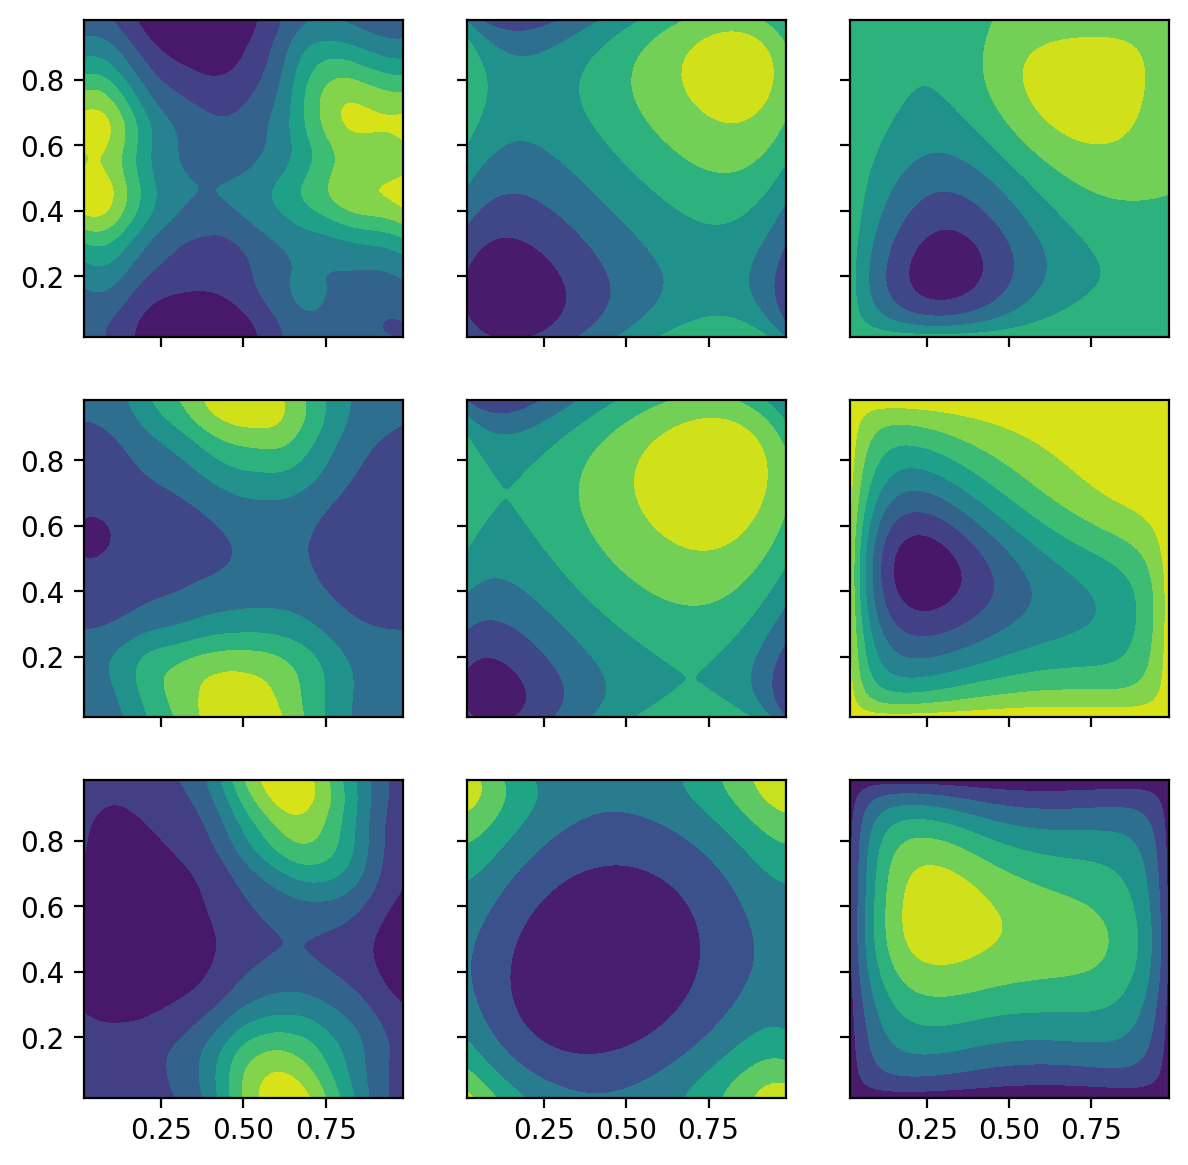

In [5]:
fig, ax = plt.subplots(3, 3, figsize=(7, 7), sharex='col', sharey='row')

key = random.PRNGKey(117)
N_samples = 3
features, targets, coordinates = get_dataset_elliptic_2D(N_samples=N_samples, normalize=True)

for j in range(N_samples):
  for i in range(2):
      ax[j, i].contourf(coordinates[0], coordinates[1], features[j, i])
  ax[j, 2].contourf(coordinates[0], coordinates[1], targets[j, 0])